In [ ]:
import tensorflow as tf
import glob, os, random

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
dataset_path = "/content/gdrive/MyDrive/DIV2K_train_HR"  # Change as needed

In [ ]:
image_paths = glob.glob(os.path.join(dataset_path, "*.*"))
print("Total images found:", len(image_paths))
random.seed(123)
random.shuffle(image_paths)
split_index = int(0.8 * len(image_paths))
train_paths = image_paths[:split_index]
test_paths = image_paths[split_index:]
print(f"Training images: {len(train_paths)}, Testing images: {len(test_paths)}")


Total images found: 788
Training images: 630, Testing images: 158


In [ ]:
def load_image_pair(image_path):
    """
    Loads an image, resizes it to 256x256 (HR), then downsamples to 64x64 (LR).
    Normalizes images to [0, 1].
    """
    hr_image = tf.io.read_file(image_path)
    hr_image = tf.image.decode_jpeg(hr_image, channels=3)
    hr_image = tf.image.resize(hr_image, (256, 256))  # High-resolution image

    lr_image = tf.image.resize(hr_image, (64, 64))    # Low-resolution image

    hr_image = hr_image / 255.0
    lr_image = lr_image / 255.0
    return lr_image, hr_image

BATCH_SIZE = 8  # Adjust smaller if you run into memory issues
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_paths)
    .map(load_image_pair, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_paths)
    .map(load_image_pair, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

print("Datasets prepared!")

Datasets prepared!


In [ ]:
from tensorflow.keras import layers, models, Input
import tensorflow as tf

# --- Dense Block (used inside RRDB) ---
def dense_block(x, growth_rate=32, num_layers=3):
    """
    A simple dense block: each layer’s output is concatenated with previous outputs.
    Reduced num_layers from 5 to 3.
    """
    concatenated = x
    for i in range(num_layers):
        tmp = layers.Conv2D(growth_rate, (3, 3), padding='same', activation='relu')(concatenated)
        concatenated = layers.Concatenate()([concatenated, tmp])
    # Fuse features: reduce channel dimension back to 64
    fused = layers.Conv2D(64, (3, 3), padding='same')(concatenated)
    return fused

# --- Residual-in-Residual Dense Block (RRDB) ---
def RRDB(x, filters=64, growth_rate=32, num_layers=3, residual_scaling=0.2):
    """
    Stacks 3 dense blocks with residual scaling and a global skip connection.
    Reduced num_layers from 5 to 3.
    """
    x_initial = x
    for _ in range(3):
        db = dense_block(x, growth_rate, num_layers)
        x = layers.Add()([x, layers.Lambda(lambda t: t * residual_scaling)(db)])
    return layers.Add()([x_initial, layers.Lambda(lambda t: t * residual_scaling)(x)])

# --- Generator Model ---
def build_generator(num_rrdb=3):
    """
    ESRGAN-style Generator:
      - Input: LR image (64x64x3)
      - Uses several RRDB blocks (reduced from 5 to 3)
      - Upsamples using subpixel convolution to produce HR output (256x256x3)
    """
    inputs = Input(shape=(64, 64, 3))

    # Initial feature extraction
    x = layers.Conv2D(64, (3, 3), padding='same')(inputs)
    x_initial = x

    # RRDB blocks (changed num_rrdb from 5 to 3)
    for _ in range(num_rrdb):
        x = RRDB(x, filters=64, growth_rate=32, num_layers=3)

    # Global skip connection
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.Add()([x, x_initial])

    # Upsampling layers: two steps to go from 64x64 -> 256x256
    for _ in range(2):
        x = layers.Conv2D(256, (3, 3), padding='same')(x)
        x = layers.Lambda(lambda t: tf.nn.depth_to_space(t, 2))(x)
        x = layers.PReLU(shared_axes=[1,2])(x)

    outputs = layers.Conv2D(3, (3, 3), padding='same', activation='sigmoid')(x)
    return models.Model(inputs, outputs, name="ESRGAN_Generator")

# Build the generator with new parameters
generator = build_generator(num_rrdb=3)
generator.summary()


Model: "ESRGAN_Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 64)     │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 32)     │         18,464 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 96)     │              0 │ conv2d[0][0],          │
│                           │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 32)     │         27,680 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 64, 64, 128)    │              0 │ concatenate[0][0],     │
│ (Concatenate)             │                        │                │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 32)     │         36,896 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 64, 64, 160)    │              0 │ concatenate_1[0][0],   │
│ (Concatenate)             │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         92,224 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 64, 64, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 64, 64)     │              0 │ conv2d[0][0],          │
│                           │                        │                │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 32)     │         18,464 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 64, 64, 96)     │              0 │ add[0][0],             │
│ (Concatenate)             │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 32)     │         27,680 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 64, 64, 128)    │              0 │ concatenate_3[0][0],   │
│ (Concatenate)             │                        │                │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 32)     │         36,896 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5        

 Total params: 1,913,379 (7.30 MB)

 Trainable params: 1,913,379 (7.30 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras import layers, models, Input

def build_discriminator():
    """
    Discriminator: a CNN that outputs the probability of an image being real.
    Modified to reduce memory usage by reducing the dense layer size.
    """
    inputs = Input(shape=(256, 256, 3))

    # Initial convolution block
    x = layers.Conv2D(64, (3, 3), strides=1, padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Downsample block 1
    x = layers.Conv2D(64, (3, 3), strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Downsample block 2
    x = layers.Conv2D(128, (3, 3), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(128, (3, 3), strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Downsample block 3
    x = layers.Conv2D(256, (3, 3), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(256, (3, 3), strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Flatten and dense layers
    x = layers.Flatten()(x)
    # Reduced dense units from 1024 to 512 to help lower memory usage
    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    return models.Model(inputs, outputs, name="Discriminator")

# Build and display the discriminator summary
discriminator = build_discriminator()
discriminator.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 262144)              │              

 Total params: 135,367,489 (516.39 MB)

 Trainable params: 135,365,825 (516.38 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

# Load VGG19 without the top layers
vgg = VGG19(weights='imagenet', include_top=False)
vgg.trainable = False

# Extract features from an intermediate layer (e.g., 'block5_conv4')
content_layer = 'block5_conv4'
vgg_content_model = tf.keras.Model(inputs=vgg.input,
                                   outputs=vgg.get_layer(content_layer).output)
vgg_content_model.trainable = False

def content_loss(hr, sr):
    """
    Compute perceptual loss between HR and SR images:
    1. Scale images to [0, 255] and preprocess for VGG19.
    2. Compute the mean squared error between their feature maps.
    """
    hr_vgg = preprocess_input(hr * 255.0)
    sr_vgg = preprocess_input(sr * 255.0)
    hr_features = vgg_content_model(hr_vgg)
    sr_features = vgg_content_model(sr_vgg)
    return tf.reduce_mean(tf.square(hr_features - sr_features))


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import time

# Optimizers for generator and discriminator
g_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Binary cross-entropy loss for adversarial training
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

@tf.function
def train_step(lr_imgs, hr_imgs):
    batch_size = tf.shape(hr_imgs)[0]
    valid = tf.ones((batch_size, 1), dtype=tf.float32)
    fake = tf.zeros((batch_size, 1), dtype=tf.float32)

    # ---- Train Discriminator ----
    with tf.GradientTape() as d_tape:
        sr_imgs = generator(lr_imgs, training=True)
        real_output = discriminator(hr_imgs, training=True)
        fake_output = discriminator(sr_imgs, training=True)
        d_loss_real = bce(valid, real_output)
        d_loss_fake = bce(fake, fake_output)
        d_loss = d_loss_real + d_loss_fake
    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
    d_optimizer.apply_gradients(zip(d_grads, discriminator.trainable_variables))

    # ---- Train Generator ----
    with tf.GradientTape() as g_tape:
        sr_imgs = generator(lr_imgs, training=True)
        fake_output = discriminator(sr_imgs, training=False)
        c_loss = content_loss(hr_imgs, sr_imgs)
        adv_loss = bce(valid, fake_output)
        g_loss = c_loss + 1e-3 * adv_loss  # You can tune the weight on adversarial loss
    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
    g_optimizer.apply_gradients(zip(g_grads, generator.trainable_variables))

    return d_loss, g_loss, c_loss, adv_loss

# Training loop
EPOCHS = 80  # Increase as needed; ESRGAN typically requires many epochs
for epoch in range(EPOCHS):
    start_time = time.time()
    d_loss_avg = 0.0
    g_loss_avg = 0.0
    step_count = 0

    for lr_batch, hr_batch in train_dataset:
        d_loss, g_loss, c_loss, a_loss = train_step(lr_batch, hr_batch)
        d_loss_avg += d_loss
        g_loss_avg += g_loss
        step_count += 1

    d_loss_avg /= step_count
    g_loss_avg /= step_count
    print(f"Epoch [{epoch+1}/{EPOCHS}]  "
          f"D_Loss: {d_loss_avg:.4f} | G_Loss: {g_loss_avg:.4f} | "
          f"Time: {time.time() - start_time:.2f}s")

print("Training complete!")


Epoch [1/80]  D_Loss: 0.5000 | G_Loss: 54.7921 | Time: 303.36s
Epoch [2/80]  D_Loss: 0.0000 | G_Loss: 52.9111 | Time: 61.43s
Epoch [3/80]  D_Loss: 0.2076 | G_Loss: 51.4409 | Time: 64.26s
Epoch [4/80]  D_Loss: 0.0158 | G_Loss: 48.8593 | Time: 62.54s
Epoch [5/80]  D_Loss: 0.0167 | G_Loss: 45.7156 | Time: 62.66s
Epoch [6/80]  D_Loss: 0.0263 | G_Loss: 42.9412 | Time: 62.91s
Epoch [7/80]  D_Loss: 0.9701 | G_Loss: 41.9099 | Time: 63.51s
Epoch [8/80]  D_Loss: 0.0000 | G_Loss: 41.1662 | Time: 63.08s
Epoch [9/80]  D_Loss: 0.0008 | G_Loss: 40.6189 | Time: 64.28s
Epoch [10/80]  D_Loss: 0.0000 | G_Loss: 40.1260 | Time: 63.41s
Epoch [11/80]  D_Loss: 0.0000 | G_Loss: 39.6989 | Time: 63.39s
Epoch [12/80]  D_Loss: 0.0000 | G_Loss: 39.3117 | Time: 63.93s
Epoch [13/80]  D_Loss: 0.0000 | G_Loss: 38.9374 | Time: 63.57s
Epoch [14/80]  D_Loss: 0.0000 | G_Loss: 38.5416 | Time: 64.18s
Epoch [15/80]  D_Loss: 0.0000 | G_Loss: 38.2171 | Time: 63.56s
Epoch [16/80]  D_Loss: 0.0000 | G_Loss: 37.8758 | Time: 63.47s


Saving 0801.png to 0801.png


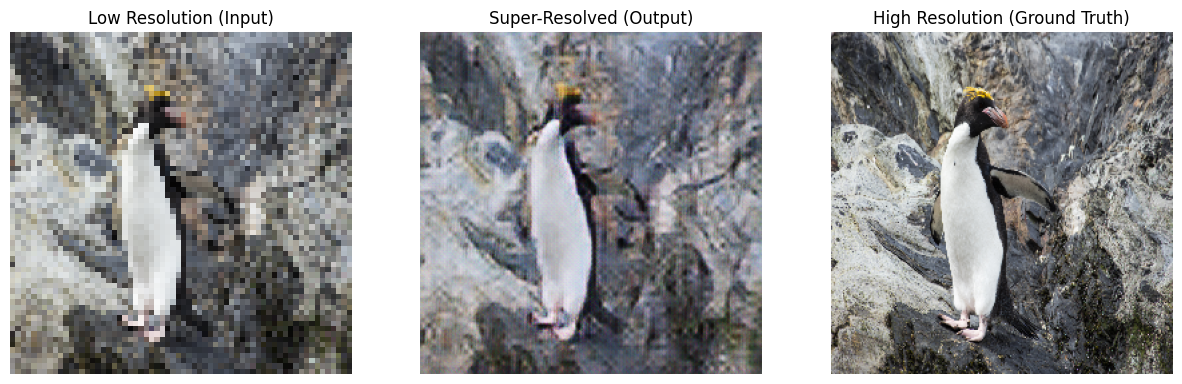

Super-resolved image saved as 'super_resolved.jpg' ✅


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab import files

# 📌 Upload an image manually
uploaded = files.upload()
test_image_path = list(uploaded.keys())[0]  # Select uploaded image

# 📌 Function to load and preprocess test image
def preprocess_test_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    hr_image = tf.image.resize(image, (256, 256))  # High-resolution
    lr_image = tf.image.resize(hr_image, (64, 64))  # Low-resolution

    return lr_image / 255.0, hr_image / 255.0  # Normalize to [0,1]

# Load test image (LR and HR)
lr_test, hr_test = preprocess_test_image(test_image_path)

# 📌 Expand dimensions for model input
lr_test_input = tf.expand_dims(lr_test, axis=0)

# 📌 Generate Super-Resolved Image
sr_output = generator(lr_test_input, training=False)
sr_output = sr_output[0].numpy()  # Convert tensor to numpy

# 📌 Display the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(lr_test.numpy())
plt.title("Low Resolution (Input)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(sr_output)
plt.title("Super-Resolved (Output)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(hr_test.numpy())
plt.title("High Resolution (Ground Truth)")
plt.axis("off")

plt.show()

# 📌 Save Super-Resolved Image
sr_image_uint8 = (sr_output * 255).astype(np.uint8)
cv2.imwrite("/content/super_resolved.jpg", cv2.cvtColor(sr_image_uint8, cv2.COLOR_RGB2BGR))

print("Super-resolved image saved as 'super_resolved.jpg' ✅")


In [ ]:
import tensorflow as tf
import numpy as np

def compute_metrics(hr_image, sr_image):
    # Convert images to uint8
    hr_image = (hr_image * 255).astype(np.uint8)
    sr_image = (sr_image * 255).astype(np.uint8)

    # Compute PSNR
    psnr_value = tf.image.psnr(sr_image, hr_image, max_val=255).numpy()

    # Compute SSIM
    ssim_value = tf.image.ssim(sr_image.astype(np.float32), hr_image.astype(np.float32), max_val=255).numpy()

    return psnr_value, ssim_value

# Compute metrics
psnr, ssim = compute_metrics(hr_test.numpy(), sr_output)

print(f"🔹 PSNR: {psnr:.2f} dB")
print(f"🔹 SSIM: {ssim:.4f}")


🔹 PSNR: 17.00 dB
🔹 SSIM: 0.2529


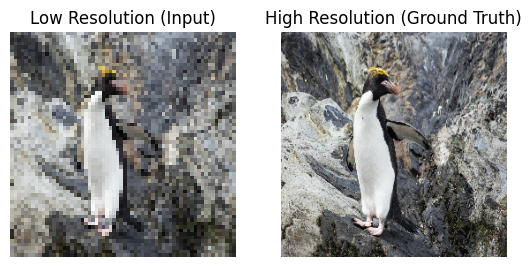

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(lr_test.numpy())
plt.title("Low Resolution (Input)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(hr_test.numpy())
plt.title("High Resolution (Ground Truth)")
plt.axis("off")

plt.show()
